# Tugas Besar IF3270 Pembelajaran Mesin
## Bagian A: Implementasi Forward Propagation untuk Feed Forward Neural Network

Anggota kelompok:

1. Christine Hutabarat (13520005)
2. Hana Fathiyah (13520047)
3. Yohana Golkaria Nainggolan (13520053)
4. Alifia Rahmah (13520122)



## 1. Perancangan struktur file eksternal untuk penyimpanan model

### Deklarasi Kelas

In [963]:
import networkx as nx
import matplotlib.pyplot as plt

class Case:
    def __init__(self, model, input, weights):
      self.model = Model(model["input_size"], model["layers"])
      self.input = input
      self.weights = weights

      def get_arr_neurons_weights(weights):
        arr_neurons = []
        for i in weights:
           arr_neurons.append(i[1:])
        return arr_neurons
      
      self.neuron_weights = get_arr_neurons_weights(self.weights)
      
      def get_arr_bias_weights(weights):
        arr_bias = []
        for i in weights:
           arr_bias.append(i[0])
        return arr_bias
      
      self.bias_weights = get_arr_bias_weights(self.weights)

class Model:
    def __init__(self, input_size, layers):
        self.input_size = input_size

        def create_array_layer(layers):
            arr_layers = []
            for i in range(len(layers)):
                arr_layers.append(Layers(layers[i]["number_of_neurons"], layers[i]["activation_function"]))
            return arr_layers

        self.layers = create_array_layer(layers)
        self.cnt_layers = len(self.layers)

    def draw_compact_structure(self):
        # input layer
        print(f'x({self.input_size})')
        print(' ↓ ')

        # hidden layer
        for i in range(len(self.layers)-1):
            print(f'h{i+1}({self.layers[i].number_of_neurons})\t= {self.layers[i].activation_function}')
            print(' ↓ ')

        # output layer
        print(f'y({self.layers[-1].number_of_neurons})\t= {self.layers[-1].activation_function}')

    def draw_structure(self, weights=None):
        G = nx.Graph()

        weight_label = {}

        # input layer
        for i in range(self.input_size + 1): # neuron+bias
            G.add_node(f'x{i}', pos=(1, i + 1)) # x1, x2, ...

        # hidden layer
        for i in range(len(self.layers) - 1): # layer+bias
            for j in range(self.layers[i].number_of_neurons + 1): # neuron+bias
                G.add_node(f'h{i+1}{j}', pos=((i + 2) * 2, j + 1)) # hi0, hi1, .., hij

                if (j > 0): # other than bias
                    if (i == 0):
                        # first hidden layer
                        for k in range(self.input_size + 1): # input layer neuron
                            G.add_edge(f'x{k}', f'h{i+1}{j}')
                            weight_label[(f'x{k}', f'h{i+1}{j}')] = weights[i][k][j-1]
                    else:
                        # previous hidden layer neurons
                         for k in range(self.layers[i-1].number_of_neurons + 1):
                            G.add_edge(f'h{i}{k}', f'h{i+1}{j}')
                            weight_label[(f'h{i}{k}', f'h{i+1}{j}')] = weights[i][k][j-1]
                
        # output layer
        for i in range(self.layers[-1].number_of_neurons): # neurons in last hidden layer
            G.add_node(f'o{i+1}', pos=((len(self.layers) + 1) * 2, i+2))
            for j in range(self.layers[-1].number_of_neurons + 1):
                G.add_edge(f'h{len(self.layers)-1}{j}', f'o{i+1}')
                weight_label[f'h{len(self.layers)-1}{j}', f'o{i+1}'] = weights[-1][j][i]
                
        pos = nx.get_node_attributes(G, 'pos')
        fig, ax = plt.subplots()
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=1000)
        nx.draw_networkx_edges(G, pos, ax=ax)
        labels = {n: n for n in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_color='white', ax=ax)
        nx.draw_networkx_edge_labels(G, pos, weight_label, ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])

        # TODO: find better way
        print("Daftar bobot:")
        print(weight_label)

        plt.show()


class Layers:
    def __init__ (self, number_of_neurons, activation_function):
        self.number_of_neurons = number_of_neurons
        self.activation_function = activation_function

    def __str__ (self):
        return f'number of neurons: {self.number_of_neurons}\nactivation_function: {self.activation_function}\n'

class Expect:
    def __init__ (self, output, max_sse):
        self.output = output
        self.max_sse = max_sse

### Deklarasi Fungsi Aktivasi

In [964]:
# Helper function
from math import exp

# net -> persamaan linear (ax+b+...)

def linear(net):
    return net

def relu(net):
    return max(0, net)

def sigmoid(net):
    return float(1/(1 + exp(net * -1)))

def softmax(net_i, arr_net):
    net_sum = 0
    for i in arr_net:
        net_sum += exp(i)

    return float(exp(net_i)/net_sum)

### Deklarasi Fungsi Pembanding (Menghitung SSE)


In [965]:
def count_sse(predict_output, expect_output):
    sse = 0.0
    
    # print predict_output
    print("predict = [", end = "")
    for i in range(len(expect_output)):
        print(predict_output[i], end="")
        if(i < len(expect_output) - 1):
            print(",", end = " ")
    print("]")

    # print expect_output
    print(f"expect = {expect_output}")

    for i in range(len(expect_output)):
        sse += (expect_output[i] - predict_output[i]) ** 2
    return sse

## 2. Implementasi load dari file teks

In [966]:
import json

def load_file(filename):
    f = open(filename)

    data = json.load(f)

    # get model
    model = data["case"]["model"]

    # get input data
    arr_input = data["case"]["input"]

    # get weights data
    arr_weight = data["case"]["weights"]

    expect_output = data["expect"]["output"]
    expect_max_sse = data["expect"]["max_sse"]

    # create object case
    case = Case(model, arr_input, arr_weight)
    expect = Expect(expect_output, expect_max_sse)

    f.close()

    return case, expect

## 3. Implementasi forward propagation

In [967]:
import numpy as np

def forward_propagation(case):
    # create array of output
    output = []

    # print count input
    print(f'{len(case.input)} Input')

    # loop for every input
    for i in range(len(case.input)):
        print("************************************")
        current_data = [case.input[i]]

        # print input idx
        print(f"input ke-{i+1}")

        # print input layer
        print(f"input layer has {len(case.input[i])} neurons")

        # print neurons
        print(f"input neurons:")
        print('x0 (bias) = 1')
        for j in range(len(case.input[i])):
            print(f'x{j+1} = {case.input[i][j]}')

        print("==================================")

        # print count of Hidden Layer
        print(f"{case.model.cnt_layers - 1} Hidden layer")

        # loop for every layer
        for j in range(case.model.cnt_layers):

            kombinasilinear = np.dot(current_data, case.neuron_weights[j]) + case.bias_weights[j]
            current_data = kombinasilinear

            current_data_cpy = current_data.copy()

            if( j == case.model.cnt_layers - 1):
                # print output layer
                print("==================================")
                print("Output layer")

            if (j < case.model.cnt_layers - 1):
                # print hidden layer
                print('----------------------------------')
                print(f"Hidden layer ke-{j+1}: {len(current_data[0])} neurons")
            else:
                # print output layer
                print(f"Output layer has {len(current_data[0])} neurons")

            # print bias
            if (j < case.model.cnt_layers - 1):
                print(f"n{j+1}0 (bias) = 1")

            # loop for every neuron
            for k in range(len(current_data[0])):

                if (case.model.layers[j].activation_function == "linear"):
                    current_data[0][k] = linear(current_data[0][k])
                if (case.model.layers[j].activation_function == "relu"):
                    current_data[0][k] = relu(current_data[0][k])
                if (case.model.layers[j].activation_function == "sigmoid"):
                    current_data[0][k] = sigmoid(current_data[0][k])
                if (case.model.layers[j].activation_function == "softmax"):
                    current_data[0][k] = softmax(
                        current_data_cpy[0][k], current_data_cpy[0])

                if (j < case.model.cnt_layers - 1):
                    # neuron in hidden layer
                    print(f"n{j+1}{k+1} = {current_data[0][k]}")
                else:
                    # neuron in output layer
                    print(f"o{j+1}{k+1} = {current_data[0][k]}")

        output.append(current_data)
        print("************************************")
    return output

### a. Menampilkan struktur jaringan

In [968]:
# TODO: add model.draw_compact_structure() implementation here after implement read file above

In [969]:
# TODO: add model.draw_structure() implementation here after implement read file above

### b. Memprediksi output untuk input 1 instance

In [970]:
case_one_instance_data = {
        "model": {
            "input_size": 3,
            "layers": [
                {
                    "number_of_neurons": 4,
                    "activation_function": "relu"
                },
                {
                    "number_of_neurons": 3,
                    "activation_function": "sigmoid"
                },
                {
                    "number_of_neurons": 2,
                    "activation_function": "softmax"
                },
                {
                    "number_of_neurons": 2,
                    "activation_function": "linear"
                }
            ]
        },
        "input": [
            [
                7.0,
                2.4,
                3.6
            ]
        ],
        "weights": [
            [
                [
                    0.6,
                    0.2,
                    1.8,
                    2.5
                ],
                [
                    2.5,
                    1.2,
                    -0.3,
                    1.4
                ],
                [
                    0.6,
                    -0.3,
                    0.7,
                    1.2
                ],
                [
                    2.2,
                    -1.3,
                    0.6,
                    1.4
                ]
            ],
            [
                [
                    1.4,
                    4.5,
                    2.4
                ],
                [
                    2.6,
                    1.2,
                    1.3
                ],
                [
                    1.1,
                    1.4,
                    -0.5
                ],
                [
                    0.1,
                    -0.4,
                    1.2
                ],
                [
                    2.4,
                    -1.6,
                    0.4
                ]
            ], 
            [
                [
                    0.7,
                    1.3
                ],
                [
                    0.5,
                    1.2
                ],
                                [
                    1.3,
                    -0.5
                ],
                [
                    2.2,
                    0.2
                ]
            ],
            [
                [
                    0.8,
                    1.3
                ],
                [
                    2.2,
                    -2.1
                ],
                [
                    -0.8,
                    1.7
                ]
            ]
        ]
    }

In [971]:
# get model
model_one_instance = case_one_instance_data["model"]

# get input data
arr_input_one_instance = case_one_instance_data["input"]

# get weights data
arr_weight_one_instance = case_one_instance_data["weights"]

# create object case
case_one_instance = Case(model_one_instance, arr_input_one_instance, arr_weight_one_instance)

In [972]:
# TODO: move to menampilkan struktur jaringan
case_one_instance.model.draw_compact_structure()

x(3)
 ↓ 
h1(4)	= relu
 ↓ 
h2(3)	= sigmoid
 ↓ 
h3(2)	= softmax
 ↓ 
y(2)	= linear


Daftar bobot:
{('x0', 'h11'): 0.6, ('x1', 'h11'): 2.5, ('x2', 'h11'): 0.6, ('x3', 'h11'): 2.2, ('x0', 'h12'): 0.2, ('x1', 'h12'): 1.2, ('x2', 'h12'): -0.3, ('x3', 'h12'): -1.3, ('x0', 'h13'): 1.8, ('x1', 'h13'): -0.3, ('x2', 'h13'): 0.7, ('x3', 'h13'): 0.6, ('x0', 'h14'): 2.5, ('x1', 'h14'): 1.4, ('x2', 'h14'): 1.2, ('x3', 'h14'): 1.4, ('h10', 'h21'): 1.4, ('h11', 'h21'): 2.6, ('h12', 'h21'): 1.1, ('h13', 'h21'): 0.1, ('h14', 'h21'): 2.4, ('h10', 'h22'): 4.5, ('h11', 'h22'): 1.2, ('h12', 'h22'): 1.4, ('h13', 'h22'): -0.4, ('h14', 'h22'): -1.6, ('h10', 'h23'): 2.4, ('h11', 'h23'): 1.3, ('h12', 'h23'): -0.5, ('h13', 'h23'): 1.2, ('h14', 'h23'): 0.4, ('h20', 'h31'): 0.7, ('h21', 'h31'): 0.5, ('h22', 'h31'): 1.3, ('h23', 'h31'): 2.2, ('h20', 'h32'): 1.3, ('h21', 'h32'): 1.2, ('h22', 'h32'): -0.5, ('h23', 'h32'): 0.2, ('h30', 'o1'): 0.8, ('h31', 'o1'): 2.2, ('h32', 'o1'): -0.8, ('h30', 'o2'): 1.3, ('h31', 'o2'): -2.1, ('h32', 'o2'): 1.7}


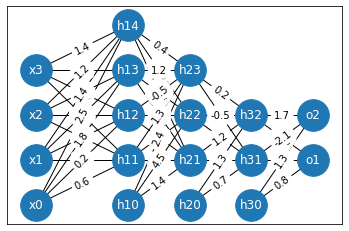

In [973]:
# TODO: move to menampilkan struktur jaringan
case_one_instance.model.draw_structure(arr_weight_one_instance)

In [ ]:
output = forward_propagation(case_one_instance)
print(output)

### c. Memprediksi output untuk input sejumlah instance

## 4. Pengujian kebenaran fungsional

### a. Memprediksi kasus dengan test case linear.json


Menggunakan model yang sudah dibuat:

In [ ]:
case_linear = load_file("linear.json")[0]
output_linear = forward_propagation(case_linear)

expect_linear = load_file("linear.json")[1]

print("Menghitung Nilai SSE")

for i in range(len(case_linear.input)):
    print('----------------------------------')
    print(f"input ke-{i+1}")
    sse = count_sse(output_linear[i][0], expect_linear.output[i])
    print(f"SSE untuk input ke-{i+1} =", sse, end = "")
    if (sse < expect_linear.max_sse):
        print(" => Result: True")
    else:
        print(" => Result: False")

### b. Memprediksi kasus dengan test case relu.json


In [ ]:
case_relu = load_file("relu.json")[0]
output_relu = forward_propagation(case_relu)

expect_relu = load_file("relu.json")[1]

print("Menghitung Nilai SSE")

for i in range(len(case_relu.input)):
    print('----------------------------------')
    print(f"input ke-{i+1}")
    sse = count_sse(output_relu[i][0], expect_relu.output[i])
    print(f"SSE untuk input ke-{i+1} =", sse, end = "")
    if (sse < expect_relu.max_sse):
        print(" => Result: True")
    else:
        print(" => Result: False")

### c. Memprediksi kasus dengan test case softmax.json

In [ ]:
case_softmax = load_file("softmax.json")[0]
output_softmax = forward_propagation(case_softmax)

expect_softmax = load_file("softmax.json")[1]

print("Menghitung Nilai SSE")

for i in range(len(case_softmax.input)):
    print('----------------------------------')
    print(f"input ke-{i+1}")
    sse = count_sse(output_softmax[i][0], expect_softmax.output[i])
    print(f"SSE untuk input ke-{i+1} =", sse, end = "")
    if (sse < expect_softmax.max_sse):
        print(" => Result: True")
    else:
        print(" => Result: False")

### d. Memprediksi kasus dengan test case sigmoid.json

In [ ]:
case_sigmoid= load_file("sigmoid.json")[0]
output_sigmoid = forward_propagation(case_sigmoid)

expect_sigmoid = load_file("sigmoid.json")[1]

print("Menghitung Nilai SSE")

for i in range(len(case_sigmoid.input)):
    print('----------------------------------')
    print(f"input ke-{i+1}")
    sse = count_sse(output_sigmoid[i][0], expect_sigmoid.output[i])
    print(f"SSE untuk input ke-{i+1} =", sse, end = "")
    if (sse < expect_sigmoid.max_sse):
        print(" => Result: True")
    else:
        print(" => Result: False")

### e. Memprediksi kasus dengan test case multilayer.json

In [ ]:
case_multilayer = load_file("multilayer.json")[0]
output_multilayer = forward_propagation(case_multilayer)

expect_multilayer = load_file("multilayer.json")[1]

print("Menghitung Nilai SSE")

for i in range(len(case_multilayer.input)):
    print('----------------------------------')
    print(f"input ke-{i+1}")
    sse = count_sse(output_multilayer[i][0], expect_multilayer.output[i])
    print(f"SSE untuk input ke-{i+1} =", sse, end = "")
    if (sse < expect_multilayer.max_sse):
        print(" => Result: True")
    else:
        print(" => Result: False")